In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.metrics import mean_squared_error, make_scorer

c:\Users\ldani\Documents\Patronus\Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar el archivo CSV
file_path = r'C:\Users\ldani\Documents\Patronus\Project\simulated-obstructive-disease-respiratory-pressure-and-flow-1.0.0/merged_dataset_balanced.csv'  # Ajusta la ruta según tu entorno
df = pd.read_csv(file_path, sep=';')

# Mostrar las primeras filas del dataframe para entender su estructura
print(df.head())

   Subject Number  Age  Gender Height [cm]  Weight [kg]  PEEP  COPD  Time [s]  \
0               1   24  Female     160-169           65     0     0      0.00   
1               1   24  Female     160-169           65     0     0      0.01   
2               1   24  Female     160-169           65     0     0      0.02   
3               1   24  Female     160-169           65     0     0      0.03   
4               1   24  Female     160-169           65     0     0      0.04   

   Pressure [cmH2O]  Flow [L/s]  V_tidal [L] History of Smoking (yes/no)  \
0          2.681998   -0.577100     0.000000                          No   
1          2.617630   -0.597392    -0.005872                          No   
2          2.681998   -0.597392    -0.011846                          No   
3          2.617630   -0.626598    -0.017966                          No   
4          2.649814   -0.626598    -0.024232                          No   

  Smoking Frequency History of vaping (yes/no) Frequency

C:\Users\ldani\AppData\Local\Temp\ipykernel_18968\3515674061.py:3: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';')


In [3]:
# Eliminar las columnas con valores faltantes
df = df.drop(columns=['Smoking Frequency', 'Frequency of vaping'])

In [4]:
# Función para convertir rangos a su valor medio
def convert_range_to_mean(value):
    if isinstance(value, str) and '-' in value:
        start, end = value.split('-')
        return (float(start) + float(end)) / 2
    return value

In [5]:
# Aplicar la función a las columnas numéricas
num_cols = ['Height [cm]']
df[num_cols] = df[num_cols].applymap(convert_range_to_mean)

# Verificar tipos de datos
print(df.dtypes)

C:\Users\ldani\AppData\Local\Temp\ipykernel_18968\4247110295.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[num_cols] = df[num_cols].applymap(convert_range_to_mean)


Subject Number                    int64
Age                               int64
Gender                           object
Height [cm]                     float64
Weight [kg]                       int64
PEEP                              int64
COPD                              int64
Time [s]                        float64
Pressure [cmH2O]                float64
Flow [L/s]                      float64
V_tidal [L]                     float64
History of Smoking (yes/no)      object
History of vaping (yes/no)       object
Asthma (yes/no and severity)     object
dtype: object


In [22]:
#Estratificamos conjunto de datos
#Dividimos el conjunto de datos en función del paciente
patient_ids = df['Subject Number'].unique()
test_patient_ids = np.random.choice(patient_ids, size=5, replace=False)  # Selecciona 5 pacientes para el conjunto de prueba
#test_patient_ids = [16, 19, 6, 17, 4]
print(test_patient_ids)


# Separar datos de prueba y entrenamiento
test_df = df[df['Subject Number'].isin(test_patient_ids)]
train_df = df[~df['Subject Number'].isin(test_patient_ids)]

# Crear conjuntos de características y etiquetas
X_train = train_df.drop(columns=['Subject Number', 'COPD'])
y_train = train_df['COPD']
X_test = test_df.drop(columns=['Subject Number', 'COPD'])
y_test = test_df['COPD']

[ 2  3 13  7  6]


In [23]:
# Convertir columnas categóricas a numéricas usando OneHotEncoder
categorical_features = ['Gender', 'History of Smoking (yes/no)', 'History of vaping (yes/no)', 'Asthma (yes/no and severity)']
numerical_features = ['Age', 'Height [cm]', 'Weight [kg]', 'PEEP', 'Time [s]', 'Pressure [cmH2O]', 'Flow [L/s]', 'V_tidal [L]']

# Crear el transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [24]:
# Preprocesar las características
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [25]:
# Crear un DataFrame combinado para AutoGluon
train_data = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
train_data['COPD'] = y_train.values
test_data = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
test_data['COPD'] = y_test.values

In [10]:
predictor = TabularPredictor.load(rf"C:\Users\ldani\Documents\Patronus\Project\AutogluonModels\ag-20240612_190315")

In [26]:
# Hacer predicciones en el conjunto de prueba
predictions = predictor.predict(test_data)
print("Predictions:\n", predictions)

# Agregar las predicciones al dataframe de prueba para verlas en contexto
test_data['Predicted_COPD'] = predictions

Predictions:
 0         152.633804
1         134.299210
2         191.758133
3         194.860260
4         198.821762
             ...    
201595    274.090485
201596    273.469727
201597    278.556641
201598    285.202850
201599    285.202850
Name: COPD, Length: 201600, dtype: float32


In [27]:
print(test_data[['COPD', 'Predicted_COPD']])

        COPD  Predicted_COPD
0          0      152.633804
1          0      134.299210
2          0      191.758133
3          0      194.860260
4          0      198.821762
...      ...             ...
201595   300      274.090485
201596   300      273.469727
201597   300      278.556641
201598   300      285.202850
201599   300      285.202850

[201600 rows x 2 columns]


c:\Users\ldani\Documents\Patronus\Project\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ldani\Documents\Patronus\Project\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


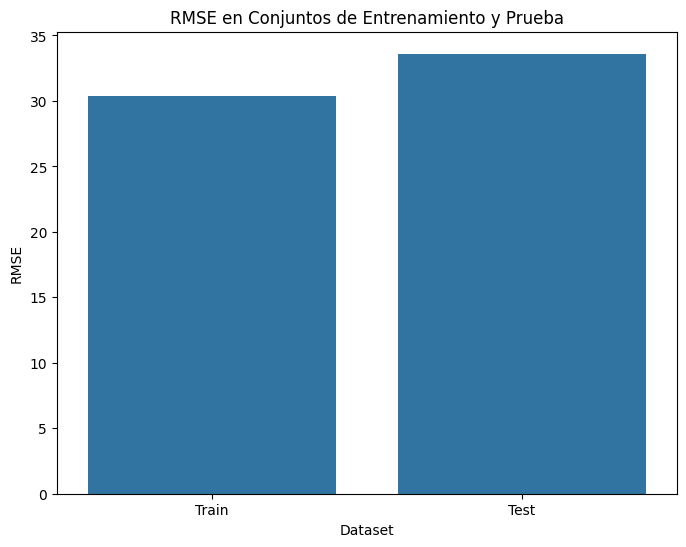

Train RMSE: 30.36662061816107
Test RMSE: 33.606284278071676


In [28]:
# Hacer predicciones en el conjunto de entrenamiento y prueba
train_predictions = predictor.predict(train_data)
test_predictions = predictor.predict(test_data)

# Calcular RMSE para el conjunto de entrenamiento y prueba
train_rmse = mean_squared_error(train_data['COPD'], train_predictions, squared=False)
test_rmse = mean_squared_error(test_data['COPD'], test_predictions, squared=False)

# Plotear los valores de RMSE
rmse_values = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Dataset', y='RMSE', data=rmse_values)
plt.title('RMSE en Conjuntos de Entrenamiento y Prueba')
plt.show()

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


In [ ]:
# Convertir numpy arrays a DataFrame
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train, columns=['COPD'])

# Concatenar X_train y y_train
train_data = pd.concat([X_train_df, y_train_df], axis=1)

# Eliminar filas con valores no finitos en la columna 'COPD'
train_data = train_data.dropna(subset=['COPD'])

# Convertir a TabularDataset
train_data = TabularDataset(train_data)

# Realizar validación cruzada usando el método 'fit'
predictor = TabularPredictor(label='COPD').fit(
    train_data=train_data,
    num_bag_folds=5,  # Número de folds para bagging (equivalente a validación cruzada)
    num_bag_sets=1,   # Número de repeticiones del proceso de bagging
    ag_args_fit={'num_gpus': 1}  # Opcional: Si tienes GPU disponible
)

# Evaluar el modelo en el conjunto de entrenamiento
train_performance = predictor.evaluate(train_data)
print("Train performance:", train_performance)

# Convertir X_test y y_test a DataFrame
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test, columns=['COPD'])

# Concatenar X_test y y_test
test_data = pd.concat([X_test_df, y_test_df], axis=1)

# Eliminar filas con valores no finitos en la columna 'COPD'
test_data = test_data.dropna(subset=['COPD'])

# Convertir a TabularDataset
test_data = TabularDataset(test_data)

# Evaluar el modelo en el conjunto de prueba
test_performance = predictor.evaluate(test_data)
print("Test performance:", test_performance)
